In [6]:
!pip install roboflow
import os
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from roboflow import Roboflow
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Roboflow API key ile bağlanma
rf = Roboflow(api_key="6ass88lllV0UMPfXoWaS")
project = rf.workspace("insectcnn").project("insect-6syav")


loading Roboflow workspace...
loading Roboflow project...


In [3]:
# Veri setinin indirilmesi
dataset = project.version(4).download("folder")

Extracting Dataset Version Zip to insect-4 in folder:: 100%|██████████| 7433/7433 [00:00<00:00, 8388.69it/s]


In [13]:
# Parametrelerin belirlenmesi
toplu_boyutu = 128
img_yukseklik = 300
img_genislik = 300

In [14]:
# Roboflow veri setlerinin yüklenmesi
# Eğitim veri setini yükleme
egitim_verisi = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/insect-4/train",
  image_size=(img_yukseklik, img_genislik),
  batch_size=toplu_boyutu
)

# Doğrulama veri setini yükleme
dogrulama_verisi = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/insect-4/valid",
  image_size=(img_yukseklik, img_genislik),
  batch_size=toplu_boyutu
)

# Test veri setini yükleme
test_verisi = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/insect-4/test",
  image_size=(img_yukseklik, img_genislik),
  batch_size=toplu_boyutu
)

# Sınıf sayısını almak için kullanabilirsiniz
sinif_sayisi = len(egitim_verisi.class_names)



Found 6488 files belonging to 3 classes.
Found 616 files belonging to 3 classes.
Found 315 files belonging to 3 classes.


In [15]:
# Modelin hazırlanması - VGG16 modelini kullanacağız
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_yukseklik, img_genislik, 3))

model = tf.keras.models.Sequential()
model.add(vgg16_model)  # VGG16 modelini ekleyelim
model.add(tf.keras.layers.Flatten())  # Düzleştirme katmanı
model.add(tf.keras.layers.Dense(1024, activation='relu'))  # Yoğun bağlantılı katman
model.add(tf.keras.layers.Dropout(0.2))  # Dropout katmanı
model.add(tf.keras.layers.Dense(1024, activation='relu'))  # Bir başka yoğun bağlantılı katman
model.add(tf.keras.layers.Dropout(0.2))  # Dropout katmanı
model.add(tf.keras.layers.Dense(sinif_sayisi, activation='softmax'))  # Çıkış katmanı

# Modelin derlenmesi
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# Verinin one-hot kodlanması
def format_image(image, label):
    return image, tf.one_hot(label, sinif_sayisi)

egitim_ds = egitim_verisi.map(format_image)
dogrulama_ds = dogrulama_verisi.map(format_image)
test_ds = test_verisi.map(format_image)

In [18]:
# Optimizasyon: Veri setinde prefetching
AUTOTUNE = tf.data.AUTOTUNE
egitim_ds = egitim_ds.prefetch(buffer_size=AUTOTUNE)
dogrulama_ds = dogrulama_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


In [19]:
# Callback'lerin ayarlanması
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("/content/gdrive/My Drive/vgg16_modelim.h5", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)


In [20]:
# Modelin Eğitilmesi
gecmis= model.fit(egitim_ds, validation_data=dogrulama_ds, epochs=20, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
51/51 [==============================] - 26s 407ms/step - loss: 1.3651 - accuracy: 0.3309 - val_loss: 1.0991 - val_accuracy: 0.3458
Epoch 2/20
51/51 [==============================] - 21s 399ms/step - loss: 1.0979 - accuracy: 0.3491 - val_loss: 1.0985 - val_accuracy: 0.3620
Epoch 3/20
51/51 [==============================] - 20s 399ms/step - loss: 1.0954 - accuracy: 0.3571 - val_loss: 1.0937 - val_accuracy: 0.3782
Epoch 4/20
51/51 [==============================] - 20s 397ms/step - loss: 1.0889 - accuracy: 0.3719 - val_loss: 1.0319 - val_accuracy: 0.4740
Epoch 5/20
51/51 [==============================] - 22s 432ms/step - loss: 0.8660 - accuracy: 0.5305 - val_loss: 0.6273 - val_accuracy: 0.6461
Epoch 6/20
51/51 [==============================] - 21s 399ms/step - loss: 0.6330 - accuracy: 0.6372 - val_loss: 0.5606 - val_accuracy: 0.6769
Epoch 7/20
51/51 [==============================] - 21s 399ms/step - loss: 0.4980 - accuracy: 0.7283 - val_loss: 0.4198 - val_accuracy: 0.8295

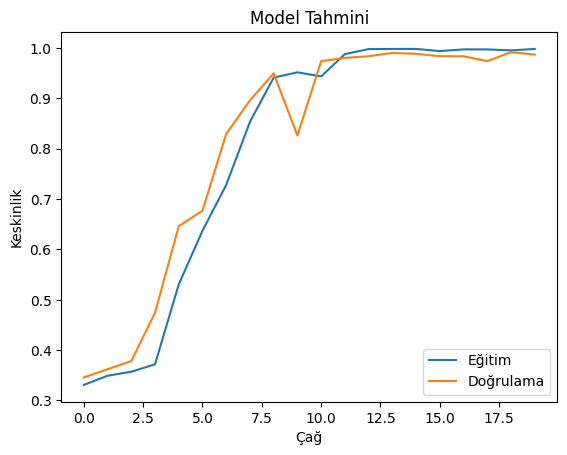

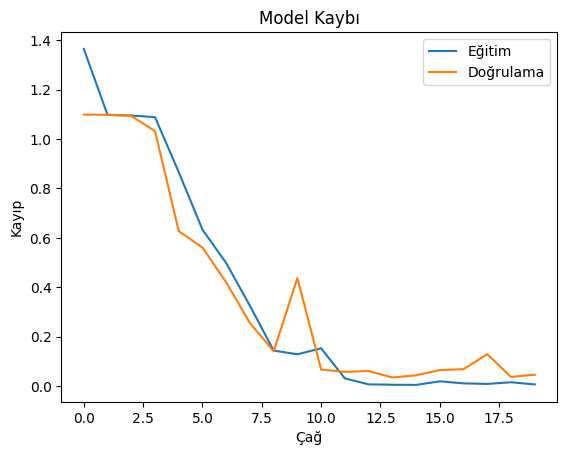

In [21]:
# Tahmin Grafiği
plt.plot(gecmis.history['accuracy'])
plt.plot(gecmis.history['val_accuracy'])
plt.title('Model Tahmini')
plt.xlabel('Çağ')
plt.ylabel('Keskinlik')
plt.legend(['Eğitim', 'Doğrulama'], loc='lower right')
plt.show()

# Kayıp Grafiği
plt.plot(gecmis.history['loss'])
plt.plot(gecmis.history['val_loss'])
plt.title('Model Kaybı')
plt.xlabel('Çağ')
plt.ylabel('Kayıp')
plt.legend(['Eğitim', 'Doğrulama'], loc='upper right')
plt.show()

3/3 [==============================] - 3s 1s/step


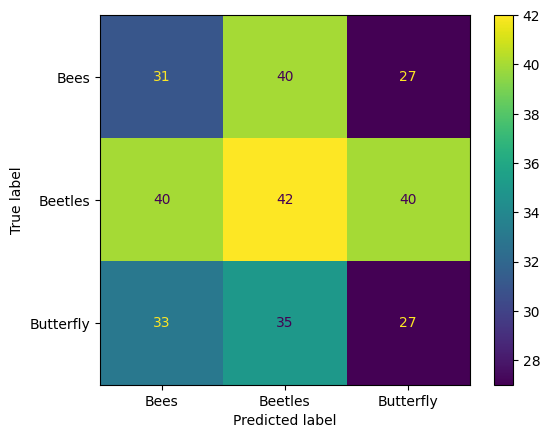

In [22]:
# Tahminleri alalım ve onları tek bir diziye dönüştürelim
predictions = model.predict(test_ds)
predicted_classes = np.argmax(predictions, axis=1)

# Gerçek etiketleri alalım ve onları tek bir diziye dönüştürelim
real_classes = []
for images, labels in test_ds:
    real_classes.extend(np.argmax(labels.numpy(), axis=1))
real_classes = np.array(real_classes)

# Doğruluk matrisini hesaplayalım
cm = confusion_matrix(real_classes, predicted_classes)

# Matrisi görselleştirelim
cmd = ConfusionMatrixDisplay(cm, display_labels=egitim_verisi.class_names)
cmd.plot()